# Homework 8

Section 9.1

Math 404

Winter 2020

<Name>

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris, load_digits
from matplotlib import pyplot as plt #For showing your image in Exercise 9.4
from time import time #There's two different modules for timing.
from timeit import timeit #take your pick.

## Exercise 9.1
Implement a naïve kNN classifier.  Your classifier should consist of a class ``kNN`` that initializes with a positive integer $k$.  It should have a ``fit`` method that accepts arrays $X$ and $y$, where $X$ has shape $N\times d$ and $y$ has length $N$ and takes discrete values.  It should also have a ``predict`` method that acepts an array ``x`` of length $d$, find the ``k`` rows in ``X`` that are nearest (in the Euclidean norm) to ``x`` and returns the label (from ``y``) that corresponds to the majority of the ``k`` neighbors.  Ensure that your code can handle ties effectively (and document clearly what your predict method does when it encounters a tie).

In [2]:
class myKNN(BaseEstimator, ClassifierMixin):
    
    def __init__(self, number_of_neighbors):
        self.k = number_of_neighbors
    
    def fit(self, X, y):
        """
        Parameters:
        X - ndarray of shape (N,d)
        y - ndarray of shape(N,)
        """
        self.X = X
        self.y = y
    
    def predict(self, x):
        """
        Predict a classification for x based on the k nearest neighbors, where k
        is the number_of_neighbors.
        
        In the case of a tie in number of neighbors with same label,
        return the label with neighbors with closest average distance.
        If tie continues at that point, return the smaller label.
        
        Parameters
        ----------
        x - ndarray of shape (m, d)
        
        Returns
        -------
        y_hat - ndarray of shape (m,)
            The predictions
        """
        x = np.array(x).reshape((-1, self.X.shape[1]))
        if x.shape[0] > 1:
            y_hat = np.array([self.predict(samp) for samp in x])
            return y_hat
        
        #Find the k nearest neighbors.
        distances = np.linalg.norm((self.X - x), axis=1);
        neighbor_indices = distances.argsort()[:self.k];
        
        #Find their distances and labels.
        neighbor_distances = distances[neighbor_indices]
        neighbor_labels = self.y[neighbor_indices];
        
        #Find the most common labels amoung the neighbors
        c = Counter(neighbor_labels)
        label, count = zip(*c.most_common())
        #assert count == sorted(count, reverse=True) #default behavior of collections.Counter.most_common() 
        
        #Determine if there is a tie
        count = np.array(count)
        number_tied = sum(count >= count[0])
        if number_tied == 1: #First is tied with self.
            return label[0] #There is no tie.
        
        #else there is a tie.  Break it.
        tied_labels = label[:number_tied]
        tied_labels = sorted(tied_labels) #labels sorted smallest to largest.
        min_avg_distance = np.inf
        label_with_min_avg_distance = None
        for l in tied_labels:
            avg_distance = neighbor_distances[neighbor_labels==l].mean()
            if avg_distance < min_avg_distance: #Further tie defaults to smaller label.
                min_avg_distance = avg_distance
                label_with_min_avg_distance = l
        
        return label_with_min_avg_distance
        

## Exercise 9.2
Using the Iris data set:

### Part (i)
Use sckikit-learn's methods to divide the iris dataset into a 70-30 train-test split.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(*load_iris(return_X_y=True), train_size=.7)

### Part (ii)
Time how fast your code from the previous problem can make a prediction for all of the test set, and compute the misclassification rate on the test set.

In [4]:
#Exercise Part (iii) and Exercise 9.3 have you do this exact same stuff, 
#just changing either the classifier, or the train set and test set.
#So, I'm making a function.
def ex92part2(clf, X_train, X_test, y_train, y_test):
    """
    Trains clf on (X_train, y_train).
    Prints prediction time on X_test.
    Prints misclassifcation rate on (X_test, y_test).
    
    Parameters
    ----------
    clf - instance of class derived from sklearn.base.ClassifierMixin
        the classifier you're testing.
        
    X_train - ndarray of shape (N,d)
        the observed values of the independent variables in the training set.
        
    y_train - ndarray of shape (N,)
        the observed values of the dependent variables in the training set.
        
    X_test - ndarray of shape (N,d)
        the observed values of the independent variables in the testing set.
        
    y_test - ndarray of shape (N,)
        the observed values of the dependent variables in the testing set.
    """
    prediction_time = None
    misclassification_rate = None
    
    #Train
    clf.fit(X_train, y_train)
    
    #Time
    prediction_time = timeit(lambda : clf.predict(X_test) , number=10)/10
    
    #Score
    misclassification_rate = clf.score(X_test, y_test)
    
    print("Prediction time:", prediction_time)
    print("Misclassification rate:", misclassification_rate)
    return
    
ex92part2(myKNN(5), X_train, X_test, y_train, y_test)

Prediction time: 0.0019079000000000069
Misclassification rate: 0.9555555555555556


### Part (iii)
Repeat the previous step using ``sklearn.neighbors.KNeighborsClassifer``.

In [5]:
sk_clf = KNeighborsClassifier(n_neighbors=5)
ex92part2(sk_clf, X_train, X_test, y_train, y_test)

Prediction time: 0.001706530000000006
Misclassification rate: 0.9555555555555556


## Exercise 9.3
Using the sklearn ``digits`` dataset (``sklearn.datasets.load_digits``) instead of the Iris dataset, repeat the three steps of the previous problem.

In [6]:
#part 1
X_train, X_test, y_train, y_test = train_test_split(*load_digits(return_X_y=True), train_size=.7)
#part 2
print("My results")
ex92part2(myKNN(5), X_train, X_test, y_train, y_test)
#part 3
print("\nScikit-Learn Results")
sk_clf = KNeighborsClassifier(n_neighbors=5)
ex92part2(sk_clf, X_train, X_test, y_train, y_test)

My results
Prediction time: 0.13450167
Misclassification rate: 0.9796296296296296

Scikit-Learn Results
Prediction time: 0.06643391000000003
Misclassification rate: 0.9777777777777777


## Exercise 9.4
Set up an account on [Kaggle.com](Kaggle.com) and enroll in the competition [www.kaggle.com/c/titanic](https://www.kaggle.com/c/titanic)

### Part (i)
Download the titanic data.

In [7]:
#We already did this in a previous assignment.  I'm going to copy/paste my work here.
cwd = os.path.abspath('') #Absolute path to directory of this notebook.
train_path = os.path.join(cwd, 'hw66_data', 'train.csv')
test_path = os.path.join(cwd, 'hw66_data', 'test.csv')
tdf = pd.read_csv(train_path)

def clean_titanic_data(tdf):
    
    df = tdf.copy(deep=True)
    
    #Add a constant column.
    df['const'] = 1

    #Dummy variables.
    embark_dummies = pd.get_dummies(df.Embarked, prefix='Embarked', dummy_na=False) #handles nans.
    gender_dummies = pd.get_dummies(df.Sex, drop_first=True)
    p_class_dummies = pd.get_dummies(df.Pclass,prefix='p_class', drop_first=True)

    #Prediction features
    prediction_features = pd.concat((df.loc[:,['Age', 'Fare', 'const']], 
                                    embark_dummies,
                                    gender_dummies,
                                    p_class_dummies)
                                    , axis=1)

    #Deal with nans in age.
    prediction_features.Age.fillna(df.Age.mean(), inplace=True)
    #Deal with nans in fare
    prediction_features.Fare.fillna(df.Fare.mean(), inplace=True)
    
    return prediction_features

X_train = clean_titanic_data(tdf)
y_train = tdf.Survived

### Part (ii)
Use your favorite binary classifier on ``sklearn`` to make predictions for the test set.

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

tdf_test = pd.read_csv(test_path)
X_test = clean_titanic_data(tdf_test)
y_hat = clf.predict(X_test)
tdf_test['Survived'] = y_hat
tdf_test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Survived  
0  34.5      0      0   330911   7.8292   NaN        Q         0  
1  47.0      1      0   363272   7.0000   NaN        S         0  
2  62.0      0      0   240276   9.6875   NaN        Q         0  
3  27.0      0      0   315154   8.6625   NaN        S         0  
4  22.0      1      1  3101298  12.2875   NaN        S         1

In [9]:
out = tdf_test.loc[:, ['PassengerId', 'Survived']]
out.set_index('PassengerId', inplace=True)
out.head(5)

Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 1

In [10]:
out.to_csv(os.path.join(cwd, 'hw91_data', 'predictions.csv'))

### Part (iii)
Submit your predictions to the competition -- take a screenshot of your submission (go to the MySubmissions tab) in a way that shows your username and score.

#### Hint:
Do not be intimidated by high scores on the Kaggle leaderboard -- people cheat in many ways.  Here are two ways to cheat on the Titanic competition:
1. Look up the historical record and acutally find out who live d and died and reverse engineer which person corresponds to which predictor $\mathbf{x}$;
2. Repeatedly submit different predictions over and over again until you get a high score.

This second cheating method is essentially just a brute-force optmization to learn the optimal classifer on the test set.  In other words, the test set has been changed into a traning set using brute-force optimization.

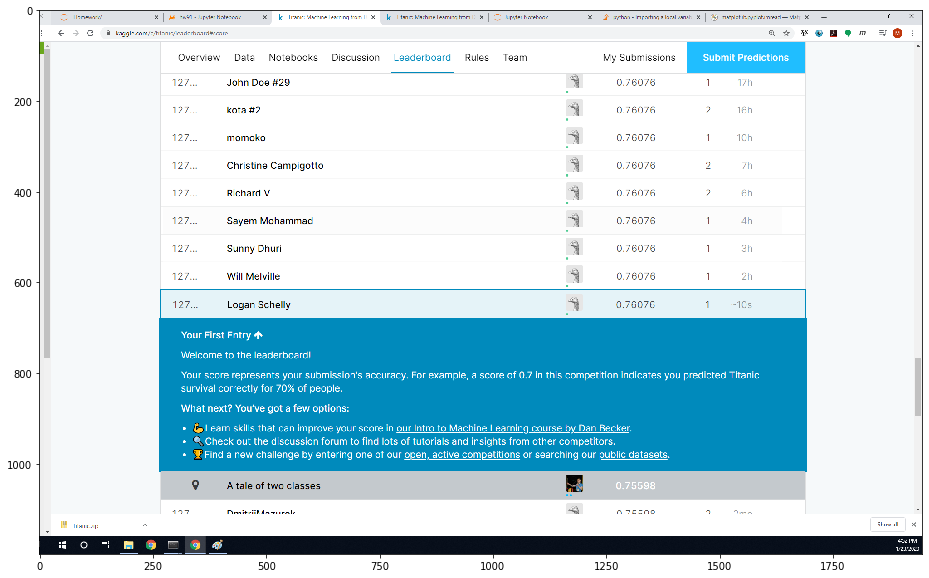

In [20]:
plt.figure(figsize=(17, 10))
plt.imshow(plt.imread(os.path.join(cwd, 'hw91_submission.png')))
plt.show()